# Imports

In [16]:
%matplotlib inline
# %matplotlib notebook
import numpy as np
import pandas as pd
import zipfile as z
import requests
import io
import matplotlib as mpl
import matplotlib.pyplot as plt
import folium
import bokeh

from bokeh.io import hplot, vform
from bokeh.models import CustomJS, ColumnDataSource, Slider
from bokeh.plotting import Figure, show, output_file
from bokeh.io import save

# from bokeh.plotting import Figure
from bokeh.models import Range1d
from bokeh.tile_providers import STAMEN_TONER
# import bokeh.plotting as bk
from bokeh.io import output_notebook
output_notebook()

import seaborn as sns
sns.set()
mpl.style.use('ggplot')
mpl.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = (20, 20)

Loading BokehJS ...

# Define function that converts longitude/latitude to Mercator
Conversion between two coordinate systems

In [3]:
def convertLatLon_XY(lat, lon):
    mapWidth    = 2*20037508.34
    mapHeight   = 2*20037508.34

    x = (lon+180)*(mapWidth/360)

    latRad = lat*np.pi/180
    mercN = np.log(np.tan((np.pi/4)+(latRad/2)))
    y     = (mapHeight/2)-(mapWidth*mercN/(2*np.pi))
    
    return (x-mapWidth/2, y-mapHeight/2)

def convertLatLon_XY_fromDf(df):
    mapWidth    = 2*20037508.34
    mapHeight   = 2*20037508.34

    df['x'] = (df.iloc[:, 2]+180)*(mapWidth/360)

    latRad = -df.iloc[:, 1]*np.pi/180
    mercN = np.log(np.tan((np.pi/4)+(latRad/2)))
    df['y']     = (mapHeight/2)-(mapWidth*mercN/(2*np.pi))
    
    df['x'] = df['x']-mapWidth/2
    df['y'] = df['y']-mapWidth/2
    
    return df

# Define function that returns map with citibike stations as circles and number of bikes as radii
Necessary for data visualization presented below

In [4]:
def plotMap(lat, lon, axis_range):
#     lat = -40.7278736
#     lon = -73.9772813
    x_offset, y_offset = convertLatLon_XY(lat, lon)
#     axis_range = 2.5e3
    x_axis_range = [-axis_range+x_offset, axis_range+x_offset]
    y_axis_range = [-axis_range+y_offset, axis_range+y_offset]
    x_range = Range1d(start=x_axis_range[0], end=x_axis_range[1])
    y_range = Range1d(start=y_axis_range[0], end=y_axis_range[1])
    p = Figure(tools='pan,wheel_zoom', x_range=x_range, y_range=y_range, plot_height=800, plot_width=800)
    p.axis.visible = False
    STAMEN_TONER.url = 'http://tile.stamen.com/toner-lite/{Z}/{X}/{Y}.png'
    p.add_tile(STAMEN_TONER)
    return p

# Download data
Automatically downloads data by year/month and extracts archive content into RAM

In [6]:
years = np.arange(2016, 2017)
# years = np.arange(2015, 2016) # uncomment to get 2015 data
months = np.arange(2, 3)
# months = np.arange(1, 13) # uncomment to get 2015 data
df = pd.DataFrame()
for year in years:
    for month in months:
        filename = "%d"%year+"%02d"%month+"-citibike-tripdata.zip"
        csvname = filename[0:-3]+'csv'
        r = requests.get('https://s3.amazonaws.com/tripdata/'+filename)
        zipfile = z.ZipFile(io.BytesIO(r.content))
        df = pd.concat([df, pd.read_csv(zipfile.open(csvname), parse_dates=[1, 2], infer_datetime_format=True)])
df = df.reset_index()
df.drop('index', axis=1, inplace=True)

# Quick look at the data
First step of Exploratory Data Analysis (EDA)

In [7]:
df.head()

tripduration           starttime            stoptime  start station id  \
0           461 2016-02-01 00:00:08 2016-02-01 00:07:49               480   
1           297 2016-02-01 00:00:56 2016-02-01 00:05:53               463   
2           280 2016-02-01 00:01:00 2016-02-01 00:05:40              3134   
3           662 2016-02-01 00:01:00 2016-02-01 00:12:02               537   
4           355 2016-02-01 00:01:41 2016-02-01 00:07:36               284   

        start station name  start station latitude  start station longitude  \
0         W 53 St & 10 Ave               40.766697               -73.990617   
1          9 Ave & W 16 St               40.742065               -74.004432   
2          3 Ave & E 62 St               40.763126               -73.965269   
3  Lexington Ave & E 24 St               40.740259               -73.984092   
4    Greenwich Ave & 8 Ave               40.739017               -74.002638   

   end station id  end station name  end station latitude  \
0             524   W 43 St & 6 Ave             40.755273   
1             380  W 4 St & 7 Ave S             40.734011   
2            3141   1 Ave & E 68 St             40.765005   
3             428    E 3 St & 1 Ave             40.724677   
4             521   8 Ave & W 31 St             40.750967   

   end station longitude  bikeid    usertype  birth year  gender  
0             -73.983169   23292  Subscriber      1966.0       1  
1             -74.002939   15329  Subscriber      1977.0       1  
2             -73.958185   22927  Subscriber      1987.0       1  
3             -73.987834   20903  Subscriber      1983.0       2  
4             -73.994442   23228  Subscriber      1978.0       1

In [8]:
df.describe()

/Users/gdavid/anaconda/lib/python3.5/site-packages/numpy/lib/function_base.py:3823: RuntimeWarning: Invalid value encountered in percentile
  RuntimeWarning)


tripduration  start station id  start station latitude  \
count  5.608740e+05     560874.000000           560874.000000   
mean   8.770950e+02        832.340691               40.737649   
std    7.302880e+03        993.172900                0.021473   
min    6.100000e+01         72.000000               40.678907   
25%    3.330000e+02        328.000000               40.722293   
50%    5.270000e+02        449.000000               40.739126   
75%    8.610000e+02        519.000000               40.751873   
max    1.811478e+06       3244.000000               40.787209   

       start station longitude  end station id  end station latitude  \
count            560874.000000   560874.000000         560874.000000   
mean                -73.986946      816.658417             40.736947   
std                   0.015209      978.926005              0.134939   
min                 -74.017134       72.000000              0.000000   
25%                 -73.997236      327.000000             40.722293   
50%                 -73.988557      447.000000             40.739017   
75%                 -73.977910      519.000000             40.751873   
max                 -73.929891     3244.000000             40.787209   

       end station longitude         bikeid     birth year         gender  
count          560874.000000  560874.000000  531048.000000  560874.000000  
mean              -73.986443   20387.262752    1976.442397       1.145337  
std                 0.242470    3011.796439      11.841593       0.484778  
min               -74.047727   14529.000000    1885.000000       0.000000  
25%               -73.997262   17729.000000            NaN       1.000000  
50%               -73.988900   21042.000000            NaN       1.000000  
75%               -73.978095   23128.000000            NaN       1.000000  
max                 0.000000   24773.000000    2000.000000       2.000000

In [9]:
df['birth year'].isnull().values.sum().sum()

29826

# EDA made faster with pivottable.js
This library makes it easy and quick to pivot and aggregate with the use of a simple GUI

In [10]:
from pivottablejs import pivot_ui

In [11]:
pivot_ui(df[0:1000])

In [12]:
df['starttime']

0        2016-02-01 00:00:08
1        2016-02-01 00:00:56
2        2016-02-01 00:01:00
3        2016-02-01 00:01:00
4        2016-02-01 00:01:41
5        2016-02-01 00:01:44
6        2016-02-01 00:02:15
7        2016-02-01 00:02:45
8        2016-02-01 00:02:56
9        2016-02-01 00:02:56
10       2016-02-01 00:02:58
11       2016-02-01 00:03:17
12       2016-02-01 00:03:42
13       2016-02-01 00:04:12
14       2016-02-01 00:05:22
15       2016-02-01 00:05:37
16       2016-02-01 00:05:41
17       2016-02-01 00:06:36
18       2016-02-01 00:07:02
19       2016-02-01 00:07:19
20       2016-02-01 00:07:20
21       2016-02-01 00:07:59
22       2016-02-01 00:08:28
23       2016-02-01 00:09:04
24       2016-02-01 00:09:52
25       2016-02-01 00:09:52
26       2016-02-01 00:10:22
27       2016-02-01 00:11:20
28       2016-02-01 00:11:41
29       2016-02-01 00:11:59
                 ...        
560844   2016-02-29 23:51:43
560845   2016-02-29 23:51:46
560846   2016-02-29 23:52:16
560847   2016-

# Create lookup table for station IDs/names

In [13]:
lut_StationNames = pd.DataFrame(df[['start station name', 
                                    'start station latitude', 
                                    'start station longitude']], 
                                index=df['start station id'])
# lut_StationNames = lut_StationNames.drop_duplicates()
lut_StationNames = lut_StationNames.groupby(level=0)
lut_StationNames = lut_StationNames.first()
lut_StationNames = convertLatLon_XY_fromDf(lut_StationNames)

In [14]:
lut_StationNamesEnded = pd.DataFrame(df[['end station name', 
                                         'end station latitude', 
                                         'end station longitude']], 
                                     index=df['end station id'])
# lut_StationNames = lut_StationNames.drop_duplicates()
lut_StationNamesEnded = lut_StationNamesEnded.groupby(level=0)
lut_StationNamesEnded = lut_StationNamesEnded.first()
lut_StationNamesEnded = convertLatLon_XY_fromDf(lut_StationNamesEnded)

# Clean-up the data

In [15]:
df = df.drop(['start station name', 'end station name'], axis=1)
df['usertype'] = df['usertype'].apply(lambda x: 1 if x=='Subscriber' else 0)
df['gender'] = df['gender'].apply(lambda x: 1 if x==0 else x)
dfBirthYearMedian = df['birth year'].median()
df['birth year'] = df['birth year'].apply(lambda x: dfBirthYearMedian if pd.isnull(x) else x)

In [16]:
df.head()

tripduration           starttime            stoptime  start station id  \
0           461 2016-02-01 00:00:08 2016-02-01 00:07:49               480   
1           297 2016-02-01 00:00:56 2016-02-01 00:05:53               463   
2           280 2016-02-01 00:01:00 2016-02-01 00:05:40              3134   
3           662 2016-02-01 00:01:00 2016-02-01 00:12:02               537   
4           355 2016-02-01 00:01:41 2016-02-01 00:07:36               284   

   start station latitude  start station longitude  end station id  \
0               40.766697               -73.990617             524   
1               40.742065               -74.004432             380   
2               40.763126               -73.965269            3141   
3               40.740259               -73.984092             428   
4               40.739017               -74.002638             521   

   end station latitude  end station longitude  bikeid  usertype  birth year  \
0             40.755273             -73.983169   23292         1      1966.0   
1             40.734011             -74.002939   15329         1      1977.0   
2             40.765005             -73.958185   22927         1      1987.0   
3             40.724677             -73.987834   20903         1      1983.0   
4             40.750967             -73.994442   23228         1      1978.0   

   gender  
0       1  
1       1  
2       1  
3       2  
4       1

# Exploration of Data

## Percentage of subscribers
95% of the users are subscribers 

In [17]:
df['usertype'].describe()

count    560874.000000
mean          0.946824
std           0.224384
min           0.000000
25%           1.000000
50%           1.000000
75%           1.000000
max           1.000000
Name: usertype, dtype: float64

## Restriction of the dataset to subscribers
Since we don't know much about the non-subscribers

In [18]:
df_subscribers = df[df['usertype']==1]

In [19]:
pivot_ui(df_subscribers[1:5000])

In [21]:
df_subscribers['birth year'].isnull().values.any()

False

Some of the birth years, for example, are not realistic

In [25]:
df_subscribers['birth year'].min()

1885.0

### Age

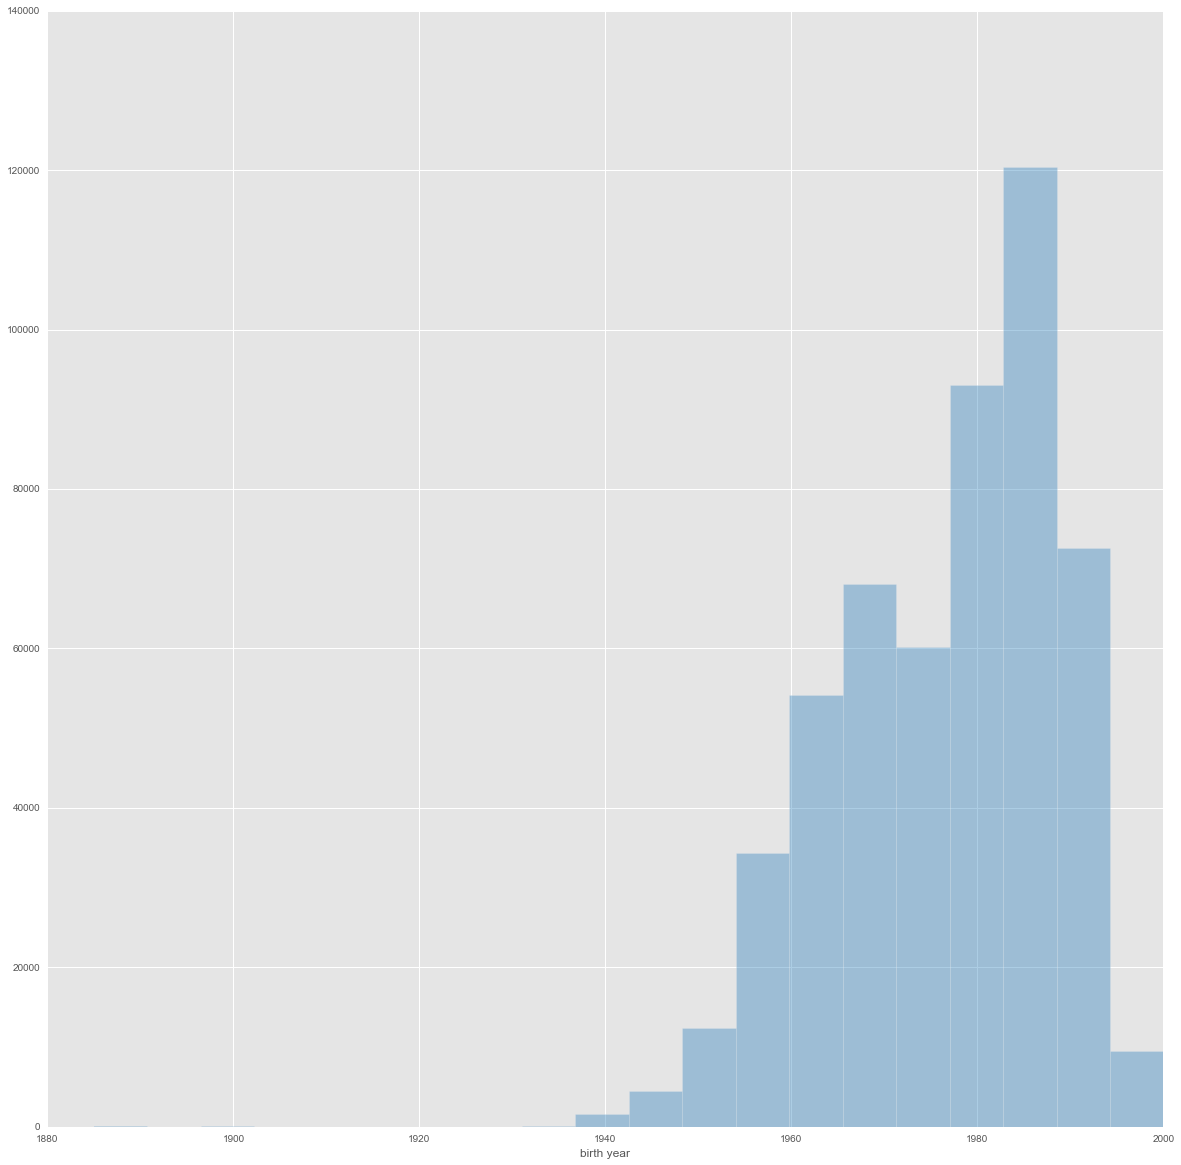

In [26]:
sns.distplot(df_subscribers['birth year'], kde=False, bins=20, color='#3182bd')

Remove entries with unrealistic birth years

In [27]:
df_birthyear = df_subscribers['birth year']
df_birthyear = df_birthyear[df_birthyear>=1915]

In [28]:
df_birthyear.describe()

count    530797.000000
mean       1976.481120
std          11.708979
min        1917.000000
25%        1968.000000
50%        1979.000000
75%        1986.000000
max        2000.000000
Name: birth year, dtype: float64

### Gender
Only 22% of the riders are female

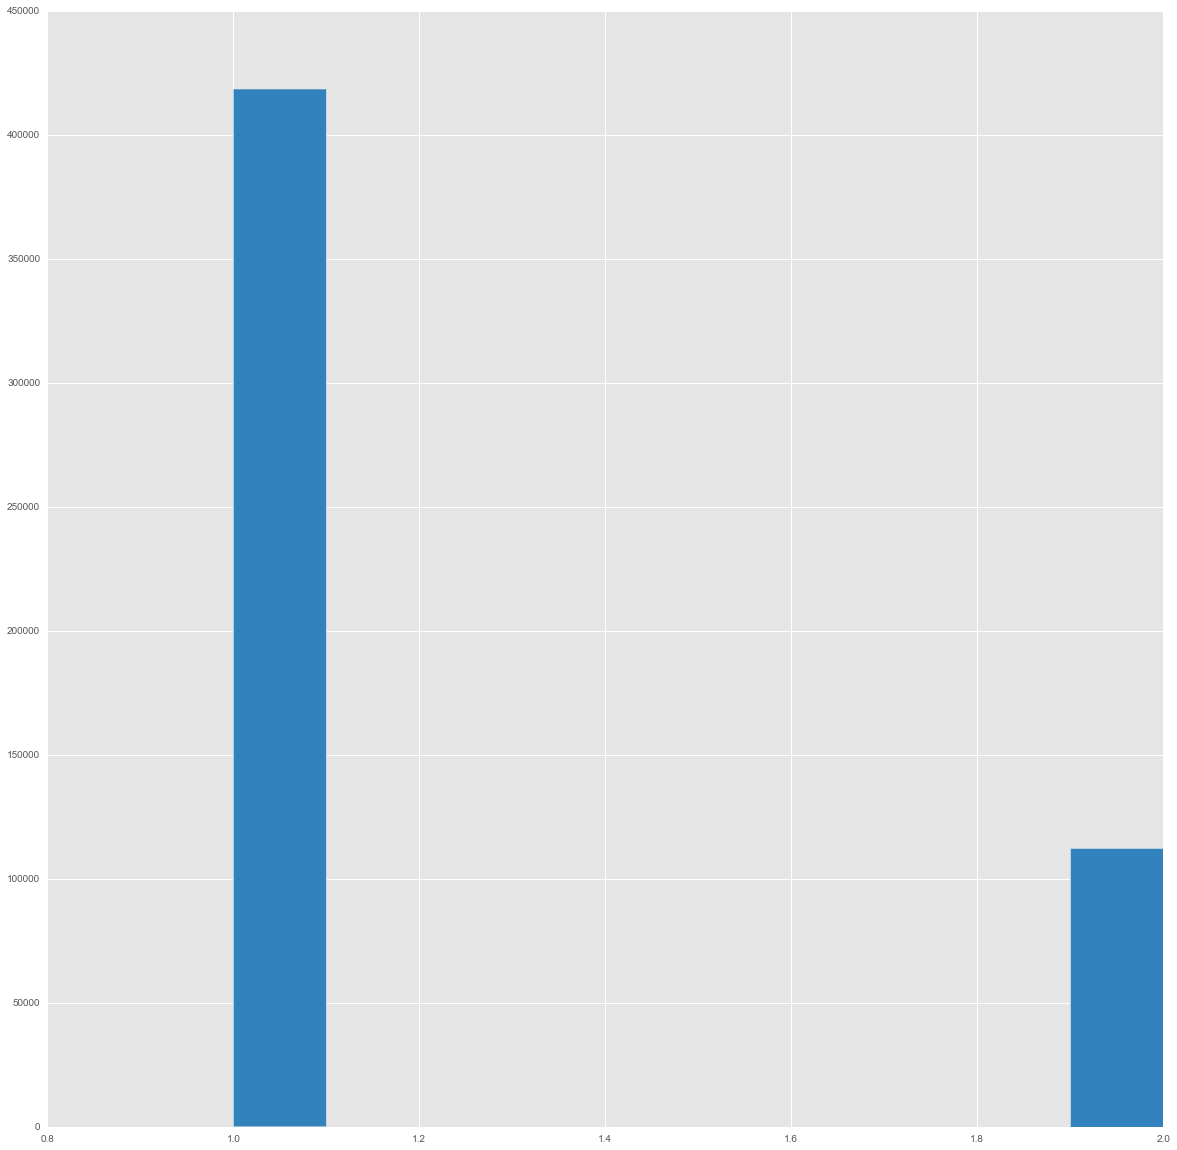

In [41]:
(df_subscribers['gender']).hist(color='#3182bd')

In [42]:
(df_subscribers['gender']-1).describe()

count    531049.000000
mean          0.212009
std           0.408731
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           1.000000
Name: gender, dtype: float64

### Trip duration and birth year vs. gender
Female subscribers are younger and take longer rides than male subscribers

In [43]:
grp = df_subscribers.groupby('gender')['tripduration', 'birth year'].mean()

In [44]:
grp

tripduration   birth year
gender                           
1         744.682509  1976.117698
2         894.767193  1977.649258

# Explore number of trips started at a given station vs. time
This visualization was done using Bokeh which is still beta. As a result we have little control over things such as the slider.

Here, the visualization includes data from 02/08/2016 to 02/14/2016. In the slider box, '1' corresponds to the first day, so 02/08/2016, '2' to the second day, so 02/09/2016, and so on and so forth...

Each Citibike station is represented by a blue circle. The radius of the circle is a function of the number of trips started at that particular location throughout the day. So the bigger the circle, the more trips were started there.

We see that most trips start in Midtown and Chelsea. We also notice that the number of trips decreases significantly during the weekend. This suggests that subscribers are commuters.

In [76]:
df_tripCount = df.loc[:, ['start station id', 'starttime']]
df_tripCount['started trips'] = 1
# df_tripCount.head()

df_tripCount = df_tripCount.groupby([pd.Grouper(freq='D', key='starttime'), 'start station id']).sum()
df_tripCount = df_tripCount.unstack(level=0)['started trips'].reset_index()
df_tripCount = pd.merge(lut_StationNames.reset_index(), df_tripCount.fillna(0))
df_tripCount['radius'] = df_tripCount.loc[:, pd.to_datetime(df_tripCount.columns[6])]
df_tripCount.columns = df_tripCount.columns.format()
# df_tripCount = df_tripCount.unstack().fillna(0).stack()

start_day = '20160208'
stop_day = '20160214'
source = ColumnDataSource(
    2*pd.concat([df_tripCount.loc[:, pd.to_datetime(start_day).strftime('%Y-%m-%d %H:%M:%S'):pd.to_datetime(stop_day).strftime('%Y-%m-%d %H:%M:%S')],
               df_tripCount.loc[:, 'radius']],
               axis=1)
)

lat = -40.7278736
lon = -73.9772813
axis_range = 5e3

plot = plotMap(lat, lon, axis_range)
plot.circle(x=df_tripCount['x'].values, 
            y=df_tripCount['y'].values, 
            radius='radius', 
            source=source,
            color='#3186cc',
            fill_color='#3186cc',
            alpha=.4)

def callback(source=source):
    data = source.get('data')
    f = cb_obj.get('value')
    date = sorted(data.keys())[f-1]
    print(date)
    r = data[date]
    data['radius'] = r
    source.trigger('change')

slider = Slider(start=1, end=len(sorted(source.data.keys())[:-4]), value=1, step=1, title="day",
                callback=CustomJS.from_py_func(callback), 
                orientation='horizontal')

layout = vform(plot, slider)

output_file(filename='TripsStartedvsTime.html', title='Trips started at a given station vs. time')

show(layout)


# Overview of hourly trips in 1 day
The code generates a figure with two maps: one with blue circles (where the trips start), one with red circles (where the trips end). The slider controls the time of the day, from midnight to midnight the following day, on a weekday. 

We notice two peaks:
- an early peak around 7-8am: trips start in Midtown and end in the Financial District, then a little bit later trips start on the West side and end on the East side.
- a late peak around 5-6pm, but the directions are less obvious

Click the 'Pop out!' link to open the visualization in a new tab. A widescreen is highly recommended.

In [69]:
df_tripStartedCount = df.loc[:, ['start station id', 'starttime']]
df_tripStartedCount['started trips'] = 1

df_tripStartedCount = df_tripStartedCount.groupby([pd.Grouper(freq='H', key='starttime'), 'start station id']).sum()
df_tripStartedCount = df_tripStartedCount.unstack(level=0)['started trips'].reset_index()
df_tripStartedCount = pd.merge(lut_StationNames.reset_index(), df_tripStartedCount.fillna(0))
df_tripStartedCount['radius'] = df_tripStartedCount.loc[:, pd.to_datetime(df_tripStartedCount.columns[6])]
df_tripStartedCount.columns = df_tripStartedCount.columns.format()

radius_factor = 20

# source = ColumnDataSource(df_tripStartedCount.iloc[:, 6:])
start_day = '20160201'
stop_day = '20160202'
source1 = ColumnDataSource(
    radius_factor*pd.concat([df_tripStartedCount.loc[:, pd.to_datetime(start_day).strftime('%Y-%m-%d %H:%M:%S'):pd.to_datetime(stop_day).strftime('%Y-%m-%d %H:%M:%S')],
               df_tripStartedCount.loc[:, 'radius']],
               axis=1)
)

lat = -40.7278736
lon = -73.9772813
lat = -40.7437815
lon = -73.9757094
axis_range = 5e3

plot1 = plotMap(lat, lon, axis_range)
plot1.circle(x=df_tripStartedCount['x'].values, 
            y=df_tripStartedCount['y'].values, 
            radius='radius', 
            source=source1,
            color='#3186cc',
            fill_color='#3186cc',
            alpha=.4)
plot1.title='Hourly volume of trips started in 1 day'

df_tripEndedCount = df.loc[:, ['end station id', 'stoptime']]
df_tripEndedCount['ended trips'] = 1

df_tripEndedCount = df_tripEndedCount.groupby([pd.Grouper(freq='H', key='stoptime'), 'end station id']).sum()
df_tripEndedCount = df_tripEndedCount.unstack(level=0)['ended trips'].reset_index()
df_tripEndedCount = pd.merge(lut_StationNamesEnded.reset_index(), df_tripEndedCount.fillna(0))
df_tripEndedCount['radius'] = df_tripEndedCount.loc[:, pd.to_datetime(df_tripEndedCount.columns[6])]
df_tripEndedCount.columns = df_tripEndedCount.columns.format()

source2 = ColumnDataSource(
    radius_factor*pd.concat([df_tripEndedCount.loc[:, pd.to_datetime(start_day).strftime('%Y-%m-%d %H:%M:%S'):pd.to_datetime(stop_day).strftime('%Y-%m-%d %H:%M:%S')],
               df_tripEndedCount.loc[:, 'radius']],
               axis=1)
)

plot2 = plotMap(lat, lon, axis_range)
plot2.circle(x=df_tripEndedCount['x'].values, 
            y=df_tripEndedCount['y'].values, 
            radius='radius', 
            source=source2,
            color='#de2d26',
            fill_color='#de2d26',
            alpha=.4)
plot2.x_range = plot1.x_range
plot2.y_range = plot1.y_range
plot2.title='Hourly volume of trips ended in 1 day'

def callback(source1=source1, source2=source2):
    data1 = source1.get('data')
    f = cb_obj.get('value')
    date = sorted(data1.keys())[f-1]
#     print(date)
    r = data1[date]
    data1['radius'] = r
    source1.trigger('change')
    data2 = source2.get('data')
#     date = sorted(data.keys())[f-1]
#     print(date)
    r = data2[date]
    data2['radius'] = r
    source2.trigger('change')

slider = Slider(start=1, end=len(sorted(source1.data.keys())[:-4]), value=1, step=1, title="hour",
                callback=CustomJS.from_py_func(callback), 
                orientation='horizontal')

layout = hplot(plot1, plot2)
# layout = vform(plot1, plot2)
layout = vform(layout, slider)

output_file(filename='OverviewOfHourlyTripsInOneDay.html', title='Overview of Hourly Trips in 1 Day')

show(layout)
# save(layout, filename='OverviewOfHourlyTripsInOneDay.html', resources=None)

class link2output:
    def _repr_markdown_(self):
        return '<a href="./OverviewOfHourlyTripsInOneDay.html" target="_blank">Pop out!</a>'
    
link2output()


<a href="./OverviewOfHourlyTripsInOneDay.html" target="_blank">Pop out!</a>

# Overview of daily trips in 1 week

In [70]:
df_tripStartedCount = df.loc[:, ['start station id', 'starttime']]
df_tripStartedCount['started trips'] = 1

df_tripStartedCount = df_tripStartedCount.groupby([pd.Grouper(freq='D', key='starttime'), 'start station id']).sum()
df_tripStartedCount = df_tripStartedCount.unstack(level=0)['started trips'].reset_index()
df_tripStartedCount = pd.merge(lut_StationNames.reset_index(), df_tripStartedCount.fillna(0))
df_tripStartedCount['radius'] = df_tripStartedCount.loc[:, pd.to_datetime(df_tripStartedCount.columns[6])]
df_tripStartedCount.columns = df_tripStartedCount.columns.format()

radius_factor = 3

# source = ColumnDataSource(df_tripStartedCount.iloc[:, 6:])
start_day = '20160201'
stop_day = '20160207'
source1 = ColumnDataSource(
    radius_factor*pd.concat([df_tripStartedCount.loc[:, pd.to_datetime(start_day).strftime('%Y-%m-%d %H:%M:%S'):pd.to_datetime(stop_day).strftime('%Y-%m-%d %H:%M:%S')],
               df_tripStartedCount.loc[:, 'radius']],
               axis=1)
)

lat = -40.7278736
lon = -73.9772813
lat = -40.7437815
lon = -73.9757094
axis_range = 5e3

plot1 = plotMap(lat, lon, axis_range)
plot1.circle(x=df_tripStartedCount['x'].values, 
            y=df_tripStartedCount['y'].values, 
            radius='radius', 
            source=source1,
            color='#3186cc',
            fill_color='#3186cc',
            alpha=.4)
plot1.title='Daily volume of trips started in 1 week'

df_tripEndedCount = df.loc[:, ['end station id', 'stoptime']]
df_tripEndedCount['ended trips'] = 1

df_tripEndedCount = df_tripEndedCount.groupby([pd.Grouper(freq='D', key='stoptime'), 'end station id']).sum()
df_tripEndedCount = df_tripEndedCount.unstack(level=0)['ended trips'].reset_index()
df_tripEndedCount = pd.merge(lut_StationNamesEnded.reset_index(), df_tripEndedCount.fillna(0))
df_tripEndedCount['radius'] = df_tripEndedCount.loc[:, pd.to_datetime(df_tripEndedCount.columns[6])]
df_tripEndedCount.columns = df_tripEndedCount.columns.format()

source2 = ColumnDataSource(
    radius_factor*pd.concat([df_tripEndedCount.loc[:, pd.to_datetime(start_day).strftime('%Y-%m-%d %H:%M:%S'):pd.to_datetime(stop_day).strftime('%Y-%m-%d %H:%M:%S')],
               df_tripEndedCount.loc[:, 'radius']],
               axis=1)
)

plot2 = plotMap(lat, lon, axis_range)
plot2.circle(x=df_tripEndedCount['x'].values, 
            y=df_tripEndedCount['y'].values, 
            radius='radius', 
            source=source2,
            color='#de2d26',
            fill_color='#de2d26',
            alpha=.4)
plot2.x_range = plot1.x_range
plot2.y_range = plot1.y_range
plot2.title='Daily volume of trips ended in 1 week'

def callback(source1=source1, source2=source2):
    data1 = source1.get('data')
    f = cb_obj.get('value')
    date = sorted(data1.keys())[f-1]
#     print(date)
    r = data1[date]
    data1['radius'] = r
    source1.trigger('change')
    data2 = source2.get('data')
#     date = sorted(data.keys())[f-1]
#     print(date)
    r = data2[date]
    data2['radius'] = r
    source2.trigger('change')

slider = Slider(start=1, end=len(sorted(source1.data.keys())[:-4]), value=1, step=1, title="day",
                callback=CustomJS.from_py_func(callback), 
                orientation='horizontal')

layout = hplot(plot1, plot2)
layout = vform(layout, slider)

output_file(filename='OverviewOfDailyTripsInOneWeek.html', title='Overview of Daily Trips in 1 Week')

show(layout)
# save(layout, 'OverviewOfDailyTripsInOneWeek.html')

class link2output:
    def _repr_markdown_(self):
        return '<a href="./OverviewOfDailyTripsInOneWeek.html" target="_blank">Pop out!</a>'
    
link2output()


<a href="./OverviewOfDailyTripsInOneWeek.html" target="_blank">Pop out!</a>

# A more traditional way to see this...
Plotting the number of trips vs. time in one day: we identify the same trends, minus the geographical information.

In [110]:
df_tripStartedCount = df.loc[:, ['starttime']]
df_tripStartedCount['started trips'] = 1

df_tripStartedCount = df_tripStartedCount.groupby([pd.Grouper(freq='30Min', key='starttime')]).sum()


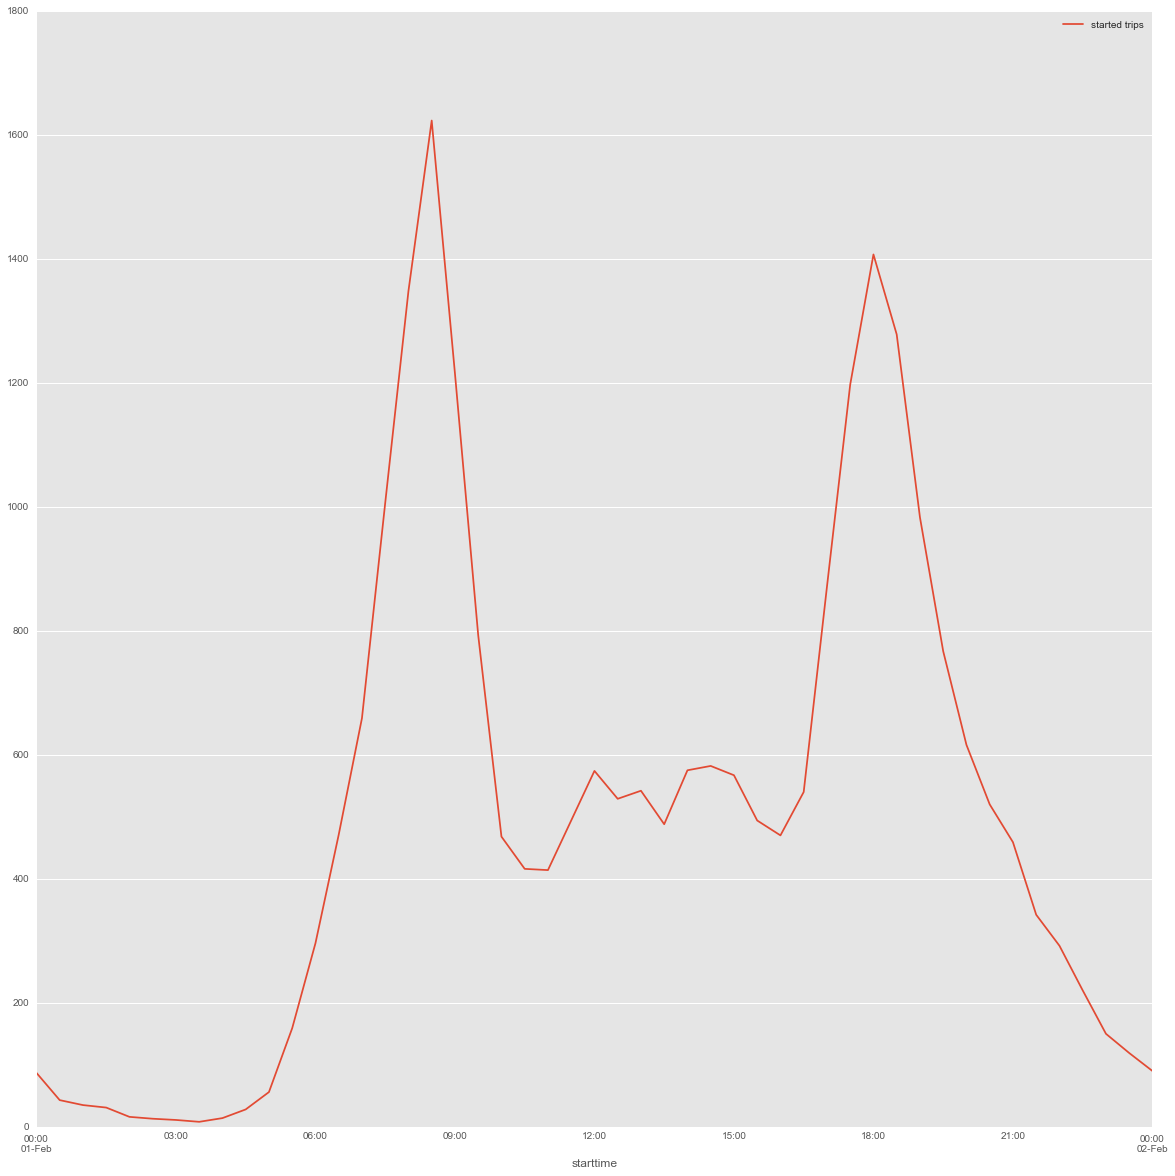

In [111]:
start_day = '20160201'
stop_day = '20160202'
df_tripStartedCount.loc[pd.to_datetime(start_day).strftime('%Y-%m-%d %H:%M:%S'):
                        pd.to_datetime(stop_day).strftime('%Y-%m-%d %H:%M:%S')].plot()

# Long term overview of the data
The first plot confirms that usage of the system during business days is primarily by commuters, with two sharp peaks at 8-9am and 5-6pm.

Usage during weekends is lighter with a broad peak in the afternoon.

# Download data
Automatically download 2 years worth of data to show usage of the system vs. time.

In [177]:
years = np.arange(2015, 2017)
months = np.arange(1, 13)
# years = [2015, ]
# months = [9, ]
df = pd.DataFrame()
for year in years:
    for month in months:
        if ((year < 2016 or month <= 5) and (year > 2015 or month >= 9)):
            filename = "%d"%year+"%02d"%month+"-citibike-tripdata.zip"
            print(filename)
            if (year == 2014 and month < 9):
                csvname = "%d"%year+"-%02d"%month+" - Citi Bike trip data.csv"
            else:
                csvname = filename[0:-3]+'csv'
            r = requests.get('https://s3.amazonaws.com/tripdata/'+filename)
            zipfile = z.ZipFile(io.BytesIO(r.content))
            tmp_df = pd.read_csv(zipfile.open(csvname), 
                                 parse_dates=[1, 2], 
                                 infer_datetime_format=True)
#             tmp_df = tmp_df.loc[:, ['starttime', 'gender']]
            tmp_df = tmp_df.loc[:, ['starttime']]
            df = pd.concat([df, tmp_df])
df = df.reset_index()
df.drop('index', axis=1, inplace=True)

201509-citibike-tripdata.zip
201510-citibike-tripdata.zip
201511-citibike-tripdata.zip
201512-citibike-tripdata.zip
201601-citibike-tripdata.zip
201602-citibike-tripdata.zip
201603-citibike-tripdata.zip
201604-citibike-tripdata.zip
201605-citibike-tripdata.zip


In [178]:
df.head()

starttime
0 2015-09-01 00:00:00
1 2015-09-01 00:00:00
2 2015-09-01 00:00:01
3 2015-09-01 00:00:07
4 2015-09-01 00:00:09

In [179]:
hour = pd.to_timedelta(df['starttime'].dt.hour, unit='H')
hour.name = 'Hour'
# df.drop('starttime', axis=1, inplace=True)

In [180]:
df_weekdays = df[df['starttime'].dt.weekday < 5]
# df_weekdays = df_weekdays.reset_index()

In [181]:
df_weekdays.head()

starttime
0 2015-09-01 00:00:00
1 2015-09-01 00:00:00
2 2015-09-01 00:00:01
3 2015-09-01 00:00:07
4 2015-09-01 00:00:09

In [150]:
grp = df_weekdays.groupby(hour).count()

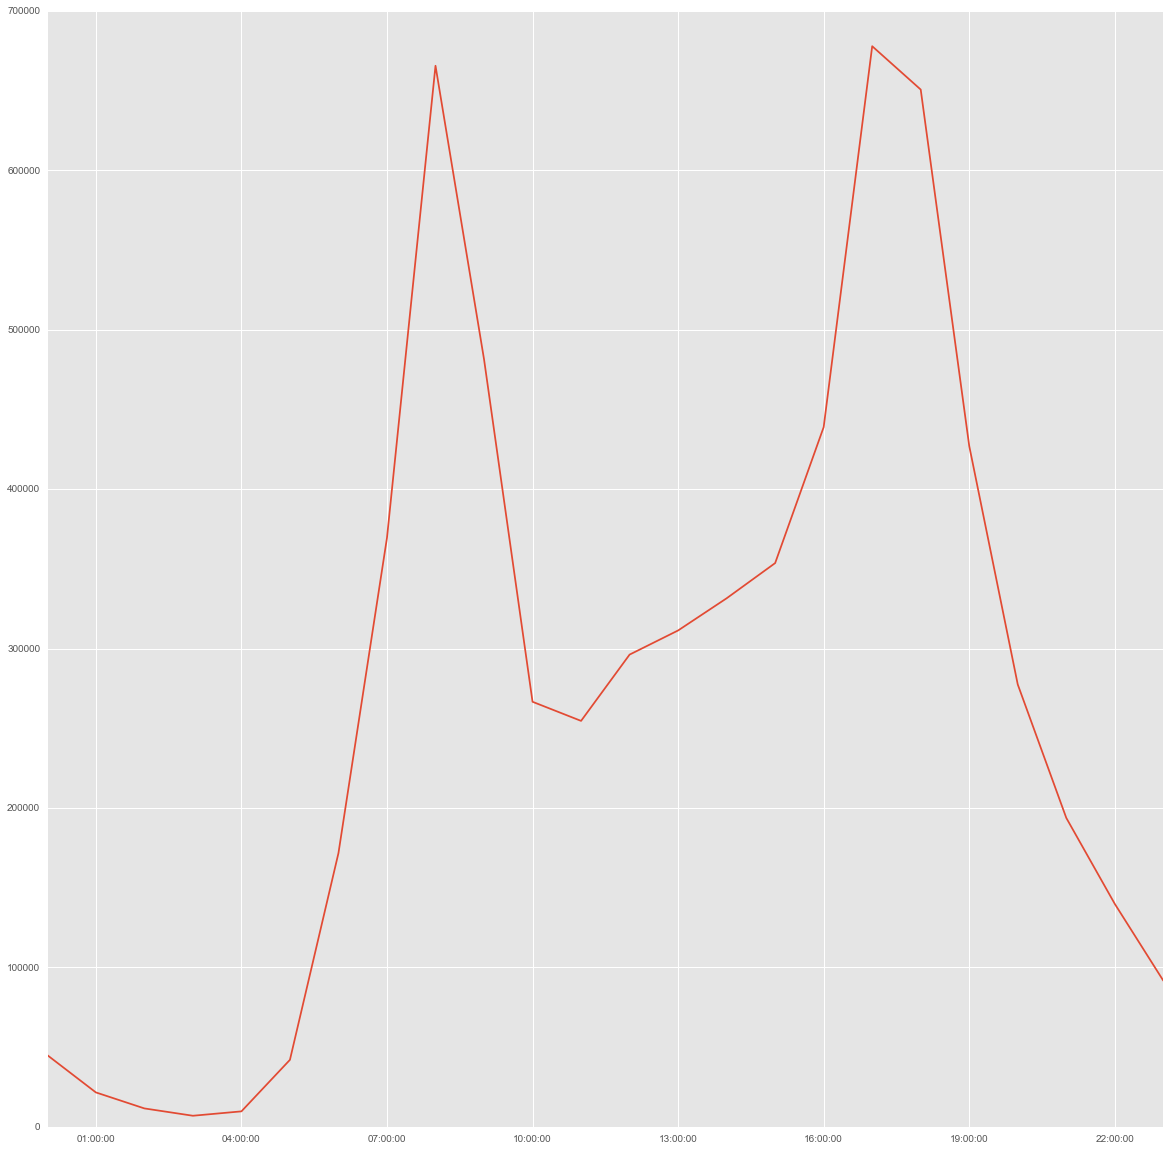

In [164]:
plt.plot(pd.to_datetime(grp.index.values), grp.values)

In [139]:
df_weekends = df[df['starttime'].dt.weekday >= 5]
# df_weekdays = df_weekdays.reset_index()

In [140]:
df_weekends.head()

starttime
169351 2015-09-05 00:00:00
169352 2015-09-05 00:00:10
169353 2015-09-05 00:00:26
169354 2015-09-05 00:00:28
169355 2015-09-05 00:00:42

In [141]:
grp = df_weekends.groupby(hour).count()

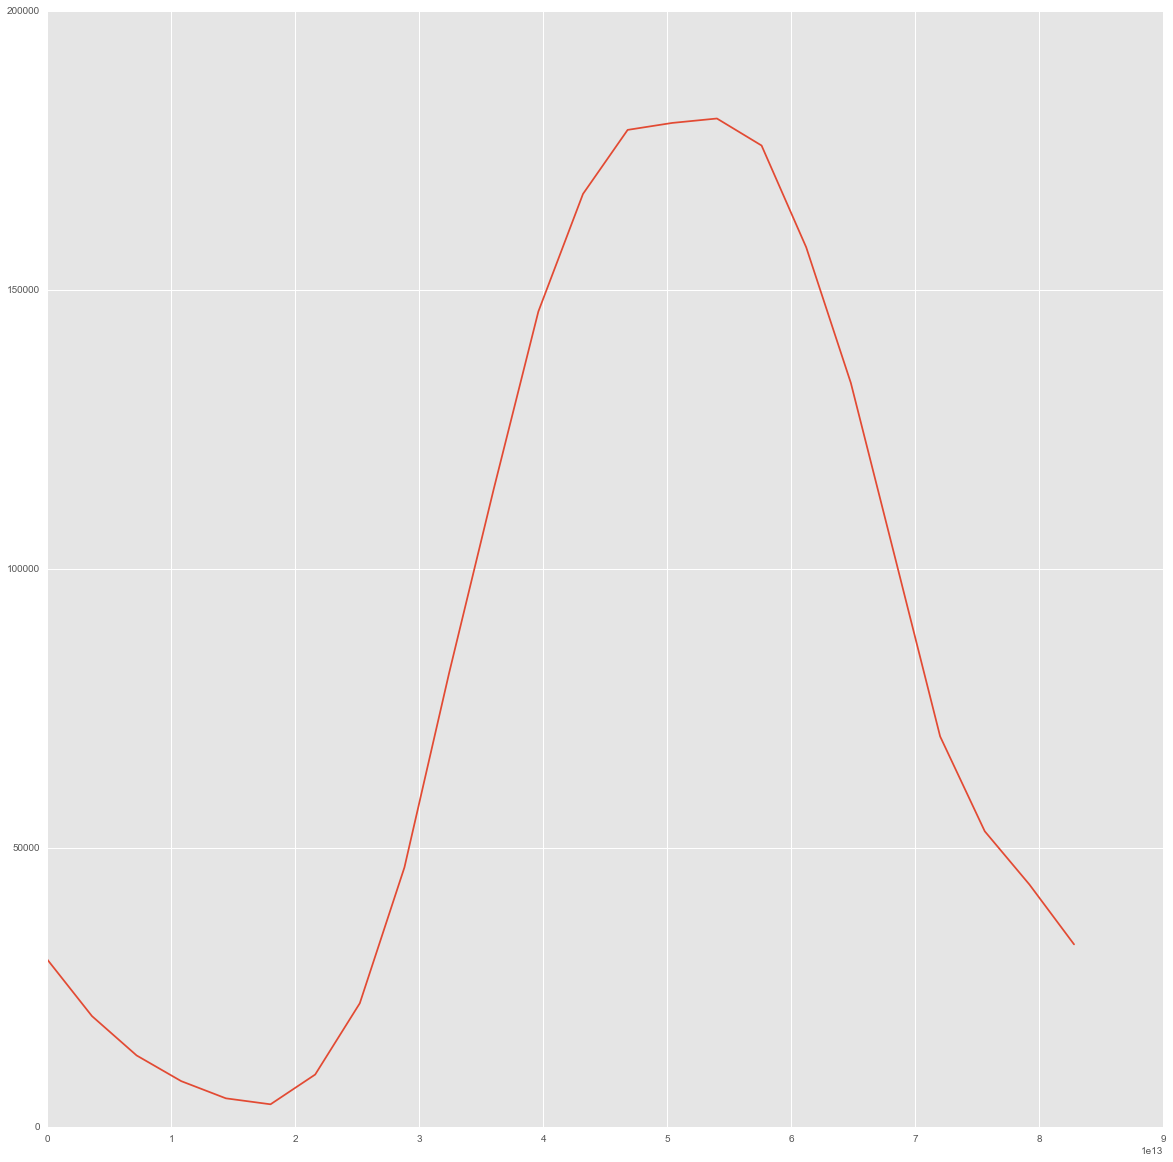

In [142]:
plt.plot(pd.to_datetime(grp.index.values), grp.values)

# Usage is seasonal
Unsurprisingly, we see from the data that the system is less used during the cold season

# Download data
Automatically download 2 years worth of data to show usage of the system vs. time.

In [190]:
years = np.arange(2013, 2017)
months = np.arange(1, 13)
# years = [2015, ]
# months = [9, ]
df = pd.DataFrame()
for year in years:
    for month in months:
        if ((year < 2016 or month <= 5) and (year > 2013 or month >= 7)):
            filename = "%d"%year+"%02d"%month+"-citibike-tripdata.zip"
            print(filename)
            if ((year == 2013) or (year == 2014 and month < 9)):
                csvname = "%d"%year+"-%02d"%month+" - Citi Bike trip data.csv"
            else:
                csvname = filename[0:-3]+'csv'
#             print(csvname)
            r = requests.get('https://s3.amazonaws.com/tripdata/'+filename)
            zipfile = z.ZipFile(io.BytesIO(r.content))
            tmp_df = pd.read_csv(zipfile.open(csvname), 
                                 parse_dates=[1, 2], 
                                 infer_datetime_format=True)
#             tmp_df = tmp_df.loc[:, ['starttime', 'gender']]
            tmp_df = tmp_df.loc[:, ['starttime']]
            df = pd.concat([df, tmp_df])
df = df.reset_index()
df.drop('index', axis=1, inplace=True)

201307-citibike-tripdata.zip
201308-citibike-tripdata.zip
201309-citibike-tripdata.zip
201310-citibike-tripdata.zip
201311-citibike-tripdata.zip
201312-citibike-tripdata.zip
201401-citibike-tripdata.zip
201402-citibike-tripdata.zip
201403-citibike-tripdata.zip
201404-citibike-tripdata.zip
201405-citibike-tripdata.zip
201406-citibike-tripdata.zip
201407-citibike-tripdata.zip
201408-citibike-tripdata.zip
201409-citibike-tripdata.zip
201410-citibike-tripdata.zip
201411-citibike-tripdata.zip
201412-citibike-tripdata.zip
201501-citibike-tripdata.zip
201502-citibike-tripdata.zip
201503-citibike-tripdata.zip
201504-citibike-tripdata.zip
201505-citibike-tripdata.zip
201506-citibike-tripdata.zip
201507-citibike-tripdata.zip
201508-citibike-tripdata.zip
201509-citibike-tripdata.zip
201510-citibike-tripdata.zip
201511-citibike-tripdata.zip
201512-citibike-tripdata.zip
201601-citibike-tripdata.zip
201602-citibike-tripdata.zip
201603-citibike-tripdata.zip
201604-citibike-tripdata.zip
201605-citibik

In [191]:
df.index = df['starttime']
df['count'] = 1

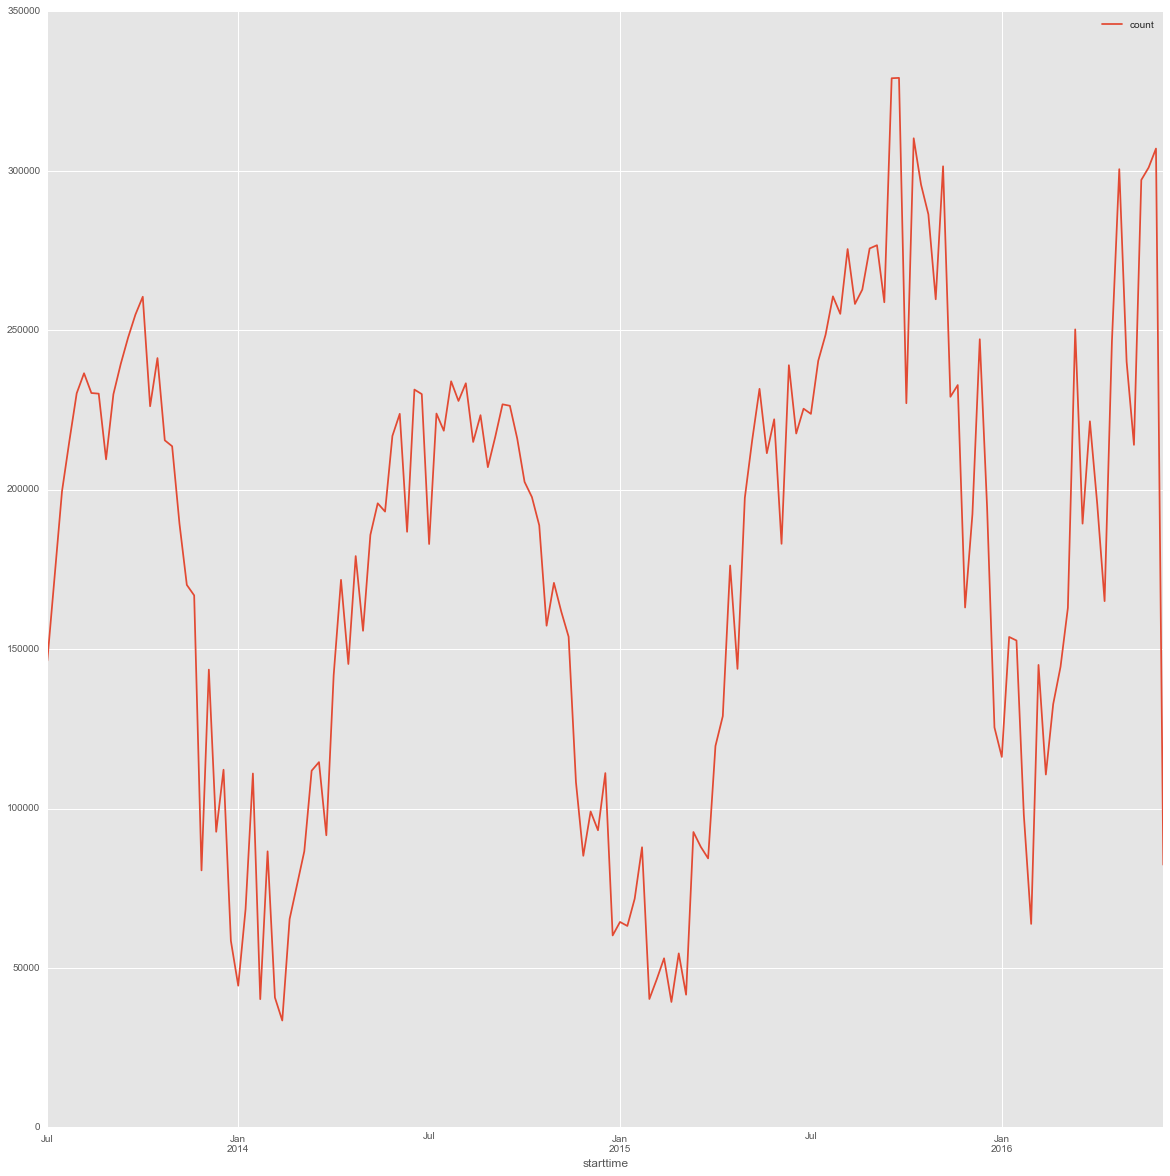

In [192]:
df.resample('W').sum().plot()